# ZZ3 Challenge Deep Learning
## Auteurs: ABDUL-SALAM Sami et TAMAGNAUD Thomas
## Références : 
    - "Image classification from scratch" de fchollet : https://keras.io/examples/vision/image_classification_from_scratch/
    - "A Basis Introduction to Separable Convolutions" de Chi-Feng Wang : https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

### Grâce à l'aide de ChatGPT et des ressources citées ci-dessus

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tk

from tensorflow.keras import layers
from tensorflow import data

## Augmentation de donnée

Technique utilisé pour améliorer la généralisation. Cela peut aussi permettre déviter le sur-apprentissage.

In [2]:
# Pipeline d'augmentation de données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # Flip horizontal
    layers.RandomRotation(0.2),          # Rotation aléatoire entre -20 et 20 degrés
    layers.RandomZoom(0.2),              # Zoom aléatoire entre 0 et 20%
    layers.RandomContrast(0.1),          # Modifie le contraste des images
    layers.RandomHeight(0.2),            # Variation de la hauteur de l'image
    layers.RandomWidth(0.2),             # Variation de la largeur de l'image
])

## Datasets

Il faut créer les objets Dataset et standariser les images aux mêmes dimensions (180x180)

In [3]:
def create_keras_dataset(directory):
    image_size = (180, 180)
    batch_size = 32

    train_ds, val_ds = tk.utils.image_dataset_from_directory(
        f"datasets/{directory}",
        validation_split=0.2,
        subset="both",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

    # Augmentation de données sur le train dataset uniquement
    train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    )

    return train_ds, val_ds

# Créer un dataset d'entraînement
train_dataset, validation_dataset  = create_keras_dataset("train")

image_size = (180, 180)

Found 14525 files belonging to 3 classes.
Using 11620 files for training.
Using 2905 files for validation.


## Conversion des datasets et Préchargement des données en mémoire

Le buffered prefetching permet de précharger les données en mémoire pendant que le modèle est occupé à les traiter. Cela évite que le modèle attende que les données soient lues depuis le disque, ce qui améliore l'efficacité.

In [4]:
def to_categorical_tensor(y):
    return tf.keras.utils.to_categorical(y, num_classes=3)

train_dataset = train_dataset.map(lambda x, y: (x, tf.py_function(to_categorical_tensor, [y], tf.float32)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.py_function(to_categorical_tensor, [y], tf.float32)))

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

## Construire un modèle

Ici, on utilise un modèle présenté dans un exemple de code du site Keras étant une version simplifiée du réseau Xception. Il s'agit d'un réseau de neurones convolutifs, étant adéquat avec la classification d'images. 

Voici les différentes couches : 

    - Couche d'entree acceptant des images de dimension 'input_shape'.
    - Couche Rescaling normalisant les valeurs des pixels de l'image en les divisant par 255 (passage de valeurs [0, 255] à [0, 1]).
    - Couche Conv2D étant une couche de convolution classique utilisée pour extraire des caractéristiques de l'image, avec un 'stride' valant 2, réduisant la taille de l'image.
    - Couche BatchNormalization permettant de normaliser les activations des couches précédentes.
    - Couche d'activation ReLU (Rectified Linear Unit).
    - Couche SeparableConv2D étant une couche de convolution séparée.
    Voici une image décrivant le concepte de cette couche, étant de diviser le noyau de 2 dimensions en deux sous noyaux d'unique dimension, réduisant le nombre d'opérations.
<img src="sep_conv.jpg" alt="Texte alternatif" width="500" height="300">

    - Couche MaxPooling2D réduisant la taille des matrices en sélectionnant les valeurs maximales dans des fenêtre de taille 3x3.
    - Couche GlobalAveragePooling2D ayant le même principe que la couche précédente en calculant la moyenne des valeurs de la fenêtre.
    - Couche Dropout permettant d'éviter le sur-apprentissage en désactivant aléatoirement une fraction des neurones lors de l'entraînement.
    - Couche Dense étant notre couche finale effectuant la classification. 

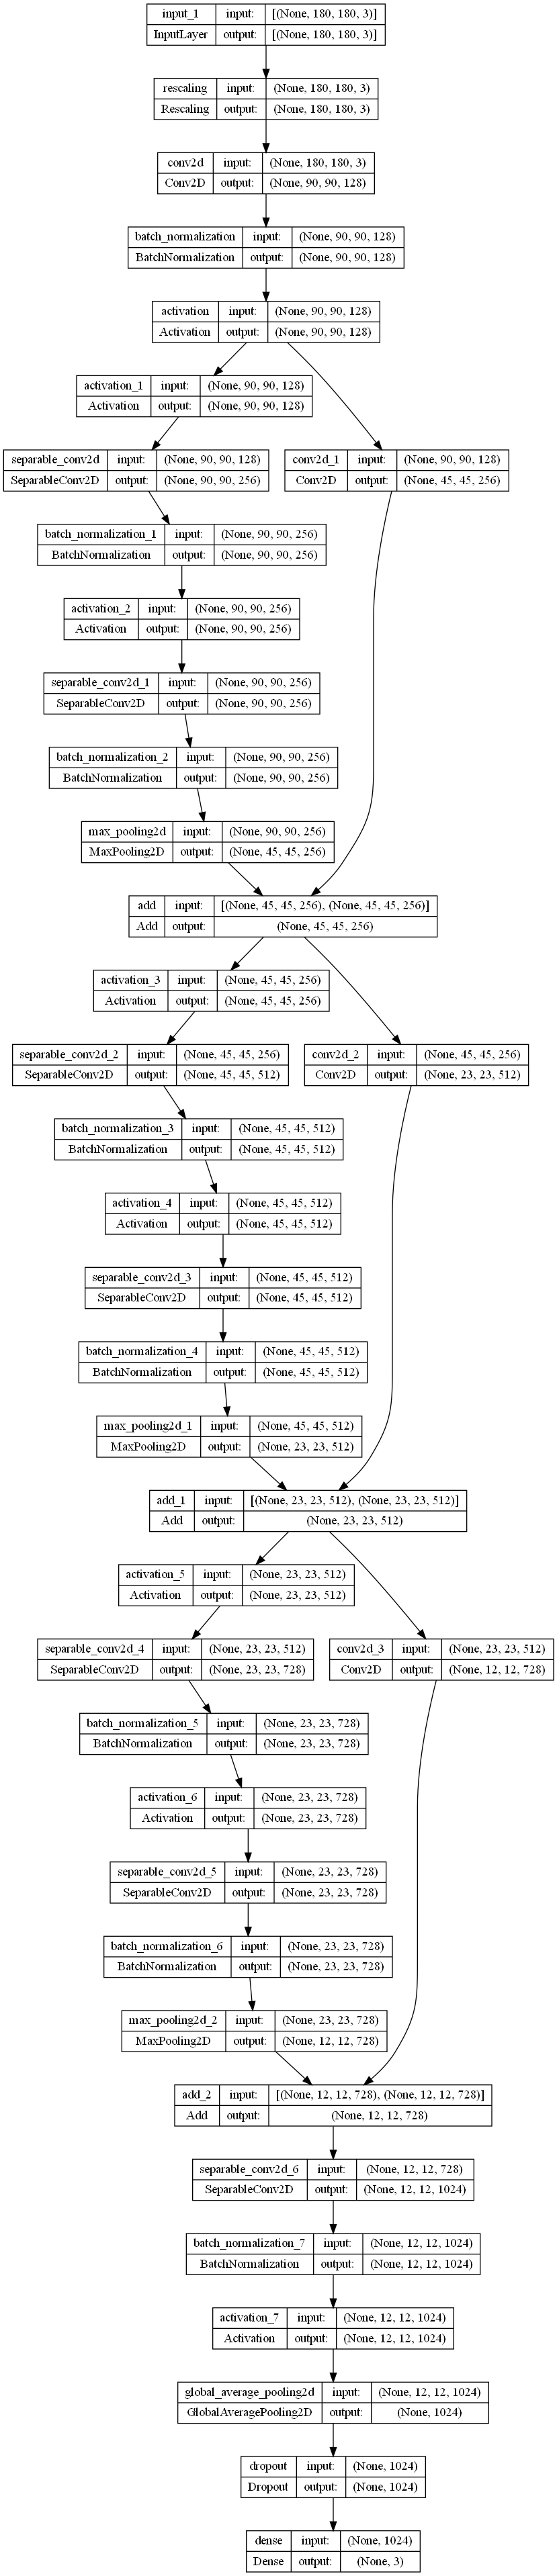

In [5]:
def make_model(input_shape, num_classes):
    inputs = tk.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
   
    units = num_classes

    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation="softmax")(x)
    return tk.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
tk.utils.plot_model(model, show_shapes=True)

## Entraînement du modèle

In [6]:
epochs = 5000

#model = load_model("best_model")

callbacks = [
    tk.callbacks.ModelCheckpoint(
        "best_model",  # Sauvegarde le modèle avec les meilleurs poids
        monitor="val_acc",  # Surveille l'accuracy sur les données de validation
        save_best_only=True,
        save_weights_only=False
    )
    # tk.callbacks.EarlyStopping(
    #     monitor="val_acc",  # Surveille l'accuracy de validation
    #     patience=5,          # Nombre d'époques sans amélioration avant d'arrêter
    #     restore_best_weights=True  # Restaure les meilleurs poids
    # )
]

model.compile(
    optimizer=tf.optimizers.Adam(3e-4),
    loss=tf.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.metrics.CategoricalAccuracy(name="acc")]
)


model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
)

Epoch 1/5000
364/364 [==============================] - ETA: 0s - loss: 0.8936 - acc: 0.5760

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 314s 823ms/step - loss: 0.8936 - acc: 0.5760 - val_loss: 1.1260 - val_acc: 0.3432
Epoch 2/5000
364/364 [==============================] - ETA: 0s - loss: 0.7972 - acc: 0.6244

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 241s 660ms/step - loss: 0.7972 - acc: 0.6244 - val_loss: 0.7868 - val_acc: 0.6217
Epoch 3/5000
364/364 [==============================] - ETA: 0s - loss: 0.7445 - acc: 0.6565

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 198s 543ms/step - loss: 0.7445 - acc: 0.6565 - val_loss: 0.7014 - val_acc: 0.6778
Epoch 4/5000
364/364 [==============================] - 177s 484ms/step - loss: 0.7159 - acc: 0.6690 - val_loss: 0.9179 - val_acc: 0.5986
Epoch 5/5000
364/364 [==============================] - ETA: 0s - loss: 0.6862 - acc: 0.6863

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 180s 494ms/step - loss: 0.6862 - acc: 0.6863 - val_loss: 0.6389 - val_acc: 0.7060
Epoch 6/5000
364/364 [==============================] - 164s 449ms/step - loss: 0.6731 - acc: 0.6953 - val_loss: 0.7516 - val_acc: 0.6534
Epoch 7/5000
364/364 [==============================] - 156s 428ms/step - loss: 0.6442 - acc: 0.7095 - val_loss: 0.6949 - val_acc: 0.6688
Epoch 8/5000
364/364 [==============================] - 150s 411ms/step - loss: 0.6343 - acc: 0.7149 - val_loss: 0.7324 - val_acc: 0.6499
Epoch 9/5000
364/364 [==============================] - 150s 411ms/step - loss: 0.6115 - acc: 0.7264 - val_loss: 0.7250 - val_acc: 0.6723
Epoch 10/5000
364/364 [==============================] - ETA: 0s - loss: 0.5999 - acc: 0.7343

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 152s 417ms/step - loss: 0.5999 - acc: 0.7343 - val_loss: 0.6411 - val_acc: 0.7112
Epoch 11/5000
364/364 [==============================] - ETA: 0s - loss: 0.5833 - acc: 0.7485

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 150s 411ms/step - loss: 0.5833 - acc: 0.7485 - val_loss: 0.6208 - val_acc: 0.7219
Epoch 12/5000
364/364 [==============================] - 144s 393ms/step - loss: 0.5719 - acc: 0.7502 - val_loss: 0.6740 - val_acc: 0.7029
Epoch 13/5000
364/364 [==============================] - ETA: 0s - loss: 0.5531 - acc: 0.7631

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 148s 407ms/step - loss: 0.5531 - acc: 0.7631 - val_loss: 0.5585 - val_acc: 0.7656
Epoch 14/5000
364/364 [==============================] - 143s 392ms/step - loss: 0.5450 - acc: 0.7674 - val_loss: 0.6304 - val_acc: 0.7133
Epoch 15/5000
364/364 [==============================] - ETA: 0s - loss: 0.5360 - acc: 0.7712

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 147s 403ms/step - loss: 0.5360 - acc: 0.7712 - val_loss: 0.5232 - val_acc: 0.7821
Epoch 16/5000
364/364 [==============================] - 142s 389ms/step - loss: 0.5254 - acc: 0.7790 - val_loss: 0.5314 - val_acc: 0.7759
Epoch 17/5000
364/364 [==============================] - 140s 384ms/step - loss: 0.5184 - acc: 0.7737 - val_loss: 0.5666 - val_acc: 0.7614
Epoch 18/5000
364/364 [==============================] - 141s 386ms/step - loss: 0.5066 - acc: 0.7874 - val_loss: 0.5857 - val_acc: 0.7511
Epoch 19/5000
364/364 [==============================] - 141s 388ms/step - loss: 0.5032 - acc: 0.7846 - val_loss: 0.5233 - val_acc: 0.7731
Epoch 20/5000
364/364 [==============================] - 140s 384ms/step - loss: 0.4864 - acc: 0.7965 - val_loss: 0.5722 - val_acc: 0.7594
Epoch 21/5000
364/364 [==============================] - ETA: 0s - loss: 0.4763 - acc: 0.7993

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 146s 400ms/step - loss: 0.4763 - acc: 0.7993 - val_loss: 0.5394 - val_acc: 0.7824
Epoch 22/5000
364/364 [==============================] - ETA: 0s - loss: 0.4728 - acc: 0.8021

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 144s 393ms/step - loss: 0.4728 - acc: 0.8021 - val_loss: 0.5146 - val_acc: 0.7855
Epoch 23/5000
364/364 [==============================] - 142s 389ms/step - loss: 0.4637 - acc: 0.8096 - val_loss: 0.5393 - val_acc: 0.7645
Epoch 24/5000
364/364 [==============================] - ETA: 0s - loss: 0.4698 - acc: 0.8028

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 144s 394ms/step - loss: 0.4698 - acc: 0.8028 - val_loss: 0.5168 - val_acc: 0.7938
Epoch 25/5000
364/364 [==============================] - 139s 381ms/step - loss: 0.4453 - acc: 0.8143 - val_loss: 0.5678 - val_acc: 0.7380
Epoch 26/5000
364/364 [==============================] - ETA: 0s - loss: 0.4431 - acc: 0.8195

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 144s 395ms/step - loss: 0.4431 - acc: 0.8195 - val_loss: 0.4945 - val_acc: 0.7972
Epoch 27/5000
364/364 [==============================] - ETA: 0s - loss: 0.4381 - acc: 0.8213

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 146s 399ms/step - loss: 0.4381 - acc: 0.8213 - val_loss: 0.4861 - val_acc: 0.7986
Epoch 28/5000
364/364 [==============================] - 139s 380ms/step - loss: 0.4308 - acc: 0.8203 - val_loss: 0.5386 - val_acc: 0.7676
Epoch 29/5000
364/364 [==============================] - 141s 387ms/step - loss: 0.4206 - acc: 0.8259 - val_loss: 0.5862 - val_acc: 0.7349
Epoch 30/5000
364/364 [==============================] - 138s 378ms/step - loss: 0.4128 - acc: 0.8294 - val_loss: 0.4959 - val_acc: 0.7862
Epoch 31/5000
364/364 [==============================] - 140s 384ms/step - loss: 0.4116 - acc: 0.8297 - val_loss: 0.5220 - val_acc: 0.7766
Epoch 32/5000
364/364 [==============================] - ETA: 0s - loss: 0.4114 - acc: 0.8295

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 143s 392ms/step - loss: 0.4114 - acc: 0.8295 - val_loss: 0.4658 - val_acc: 0.8141
Epoch 33/5000
364/364 [==============================] - 140s 382ms/step - loss: 0.4009 - acc: 0.8373 - val_loss: 0.4733 - val_acc: 0.8083
Epoch 34/5000
364/364 [==============================] - 138s 378ms/step - loss: 0.3974 - acc: 0.8396 - val_loss: 0.4671 - val_acc: 0.8096
Epoch 35/5000
364/364 [==============================] - 140s 384ms/step - loss: 0.3929 - acc: 0.8404 - val_loss: 0.4894 - val_acc: 0.7976
Epoch 36/5000
364/364 [==============================] - 139s 381ms/step - loss: 0.3837 - acc: 0.8459 - val_loss: 0.4881 - val_acc: 0.8000
Epoch 37/5000
364/364 [==============================] - 139s 380ms/step - loss: 0.3767 - acc: 0.8475 - val_loss: 0.5049 - val_acc: 0.7886
Epoch 38/5000
364/364 [==============================] - 137s 376ms/step - loss: 0.3695 - acc: 0.8496 - val_loss: 0.6248 - val_acc: 0.7518
Epoch 39/5000
364/364 [==================

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


364/364 [==============================] - 142s 391ms/step - loss: 0.3472 - acc: 0.8606 - val_loss: 0.4757 - val_acc: 0.8186
Epoch 44/5000
364/364 [==============================] - 138s 378ms/step - loss: 0.3443 - acc: 0.8606 - val_loss: 0.5022 - val_acc: 0.7890
Epoch 45/5000
364/364 [==============================] - 138s 379ms/step - loss: 0.3369 - acc: 0.8663 - val_loss: 0.6079 - val_acc: 0.7663
Epoch 46/5000
297/364 [=======================>......] - ETA: 24s - loss: 0.3303 - acc: 0.8656

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/batch_normalization_2/FusedBatchNormGradV3' defined at (most recent call last):
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\SamiG\AppData\Local\Temp\ipykernel_5620\1637536013.py", line 24, in <module>
      model.fit(
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\SamiG\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/batch_normalization_2/FusedBatchNormGradV3'
OOM when allocating tensor with shape[32,256,106,104] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/batch_normalization_2/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8801]

## Evaluation des performances du modèle enregistré

In [7]:
from tensorflow.keras.models import load_model
model = load_model("best_model")

test_dataset = tk.utils.image_dataset_from_directory(
        "datasets/test",
        image_size=(180, 180),
        shuffle=True,
    )
test_dataset = test_dataset.map(lambda x, y: (x, tf.py_function(to_categorical_tensor, [y], tf.float32)))

loss, accuracy = model.evaluate(test_dataset)

Found 1643 files belonging to 3 classes.
52/52 [==============================] - 8s 114ms/step - loss: 0.4986 - acc: 0.7912


## Affichage des images avec leurs prédictions

1/1 [==============================] - 0s 342ms/step


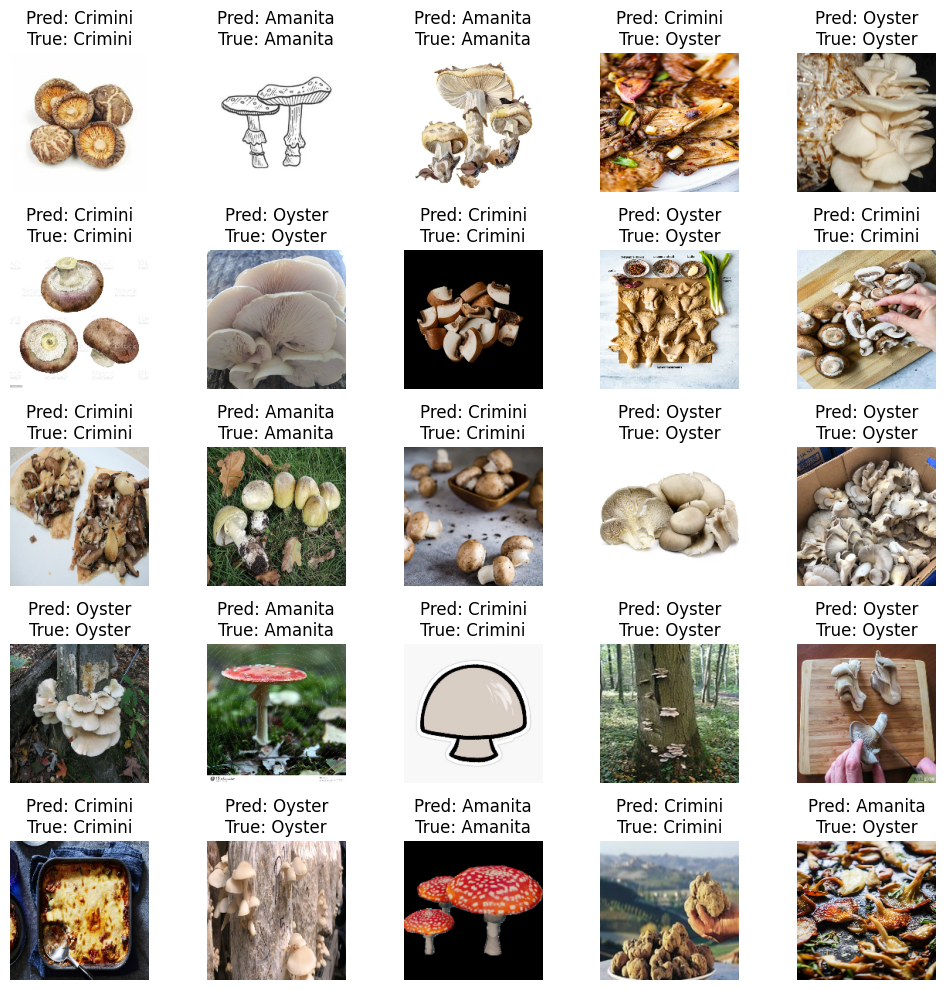

In [8]:
# Dictionnaire pour le mappage des classes
class_mapping = {0: "Amanita", 1: "Crimini", 2: "Oyster"}

for images, labels in test_dataset.take(1):  # Prenons un seul batch
    # Faire une prédiction avec le modèle
    predictions = model.predict(images)
    
    # Trouver la classe prédite pour chaque image
    predicted_classes = np.argmax(predictions, axis=-1)
    true_classes = np.argmax(labels, axis=-1)

    # Afficher les images avec la prédiction et la vérité attendue
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 25)):  # Afficher au maximum 25 images
        image = images[i].numpy()  # Convertir l'image en numpy array
        true_label = class_mapping[true_classes[i]]
        predicted_label = class_mapping[predicted_classes[i]]

        # Normaliser les images si elles sont en float avec des valeurs [0, 255]
        if image.max() > 1.0:
            image = image / 255.0

        plt.subplot(5, 5, i + 1)
        if image.shape[-1] == 1:  # Si l'image est en niveaux de gris
            plt.imshow(np.squeeze(image), cmap='gray')
        else:  # Si l'image est RGB
            plt.imshow(image)
        
        # Afficher la prédiction et la vérité attendue
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
